# Factor : News Coverage 

by **Subarna Chowdhury Soma** [SJSU ID: 014549587]

> * Project : Alternus Vera Iteration 1
> * Team: The Mean Squares
> * Colab 1: Factor_NewsCoverage_StoryClustering.ipynb
> * Colab 2: Factor_NewsCoverage_ScoreComputing.ipynb

# Mount Drive

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Load
### Imports
The first step is to import some of the required packages.

In [0]:
import argparse
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ParameterGrid
import csv
import nltk


In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Parameter configuration 


Kaggle Data : https://www.kaggle.com/snapcrack/all-the-news/home

In [0]:
runParams={'tfidf_maxdf':      [0.5],
           'input_file':       ['/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/all-news-kaggle/articles.csv'],
           'story_threshold':  [0.26],
           'process_date':     ['2016-09-01'],
           'parts_of_speech':  [['PROPER', 'VERB']],
           'lemma_conversion': [False],
           'ngram_max':        [3],
           'tfidf_binary':     [False],
           'tfidf_norm':       ['l2'],
           'nlp_library':      ['nltk'],
           'max_length':       [50],
           'stop_words_file':  ['/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/all-news-kaggle/stopWords.txt'],
           'tfidf_mindf':      [2],
           'display_graph':    [True],
           'article_stats':    [False]}

# Use parameter grid even if there is only set of parameters
parameterGrid=ParameterGrid(runParams)

### Loading-NLP Libraries


In [0]:
# Load and initialise required NLP libraries
pos_nlp_mapping={}
nl=None
wordnet_lemmatizer=None
nlp=None
if 'spaCy' in runParams['nlp_library']:
	import spacy
	nlp=spacy.load('en')
	pos_nlp_mapping['spaCy']={'VERB':['VERB'],'PROPER':['PROPN'],'COMMON':['NOUN']}

if 'nltk' in runParams['nlp_library']:
	import nltk as nl
	if True in runParams['lemma_conversion']:
		from nltk.stem import WordNetLemmatizer
		wordnet_lemmatizer=WordNetLemmatizer()
	else:
		wordnet_lemmatizer=None
	pos_nlp_mapping['nltk']={'VERB':['VB','VBD','VBG','VBN','VBP','VBZ'],'PROPER':['NNP','NNPS'],'COMMON':['NN','NNS']}

# Preprocessing and Data Analysis

## Nan Value Check

In [0]:
df_=pd.read_csv(runParams['input_file'][0])
df_=df_.drop_duplicates('content')
df_=df_[~df_['content'].isnull()]

In [14]:
df_.shape

(673, 10)

In [15]:
df_.date.unique()

array(['2016-12-02', '2016-09-01'], dtype=object)

### Inspect loaded articles
Now that the articles are loaded, the only attributes that will be used are the ID and the 'content no non-ascii' column.

## Junk Article Removal

* There are a large number of junk articles, many of which either don't make sense or
* just contain a headline 

In [0]:
def cleanData(filename,processDate,printSummary=False):

	df=pd.read_csv(filename)
	df=df.drop_duplicates('content')
	df=df[~df['content'].isnull()]

	df=df[df['content'].str.len()>=200]

	# Find and remove summary NYT "briefing" articles to avoid confusing the clustering
	targetString="(Want to get this briefing by email?"
	df['NYT summary']=df['content'].map(lambda d: d[:len(targetString)]==targetString)
	df=df[df['NYT summary']==False]

	targetString="For us to continue writing great stories, we need to display ads.             Please select the extension that is blocking ads.     Please follow the steps below"
	df['content']=df['content'].str.replace(targetString,'')

	# This is also for some Atlantic articles for the same reasons as above
	targetString="This article is part of a feature we also send out via email as The Atlantic Daily, a newsletter with stories, ideas, and images from The Atlantic, written specially for subscribers. To sign up, please enter your email address in the field provided here."
	df=df[df['content'].str.contains(targetString)==False]

	# This is also for some Atlantic articles for the same reasons as above
	targetString="This article is part of a feature we also send out via email as Politics  Policy Daily, a daily roundup of events and ideas in American politics written specially for newsletter subscribers. To sign up, please enter your email address in the field provided here."
	df=df[df['content'].str.contains(targetString)==False]

	# More Atlantic-specific removals (for daily summaries with multiple stories contained)
	df=df[df['content'].str.contains("To sign up, please enter your email address in the field")==False]

	# Remove daily CNN summary
	targetString="CNN Student News"
	df=df[df['content'].str.contains(targetString)==False]

	if printSummary:
		print("\nArticle counts by publisher:")
		print(df['publication'].value_counts())

		print("\nArticle counts by date:")
		print(df['date'].value_counts())
		
	if processDate!=None:
		df=df[df['date']==processDate]
	df.reset_index(inplace=True, drop=True)

	# Remove non-ASCII characters
	df['content no nonascii']=df['content'].map(lambda x: removeNonASCIICharacters(x))

	#print("\nFinal dataset:\n\nDate:",processDate,"\n")
	print(df.head())

	return df

##########################################################################################

def removeNonASCIICharacters(textString): 
    return "".join(i for i in textString if ord(i)<128)

In [17]:
articleDataFrame = cleanData(runParams['input_file'][0],
                            runParams['process_date'][0],
                            printSummary=False)

   Unnamed: 0  ...                                content no nonascii
0        3722  ...  Another Earth could be circling the star right...
1        3748  ...  The anodyne welcome letter to incoming freshme...
2        3754  ...  CASETTA, Italy     Romano Camassi, a seismolog...
3        3755  ...  In the late 1990s, General Motors got an unexp...
4        3772  ...  Gene Wilder, who established himself as one of...

[5 rows x 12 columns]


In [18]:
articleDataFrame.shape

(302, 12)

## Article counts by publisher


Article counts by publisher:
Breitbart           104
NY Post              61
CNN                  58
Reuters              56
NPR                  54
NY Times             52
Atlantic             52
Washington Post      51
Buzzfeed News        48
Business Insider     42
Guardian             35
National Review      32
Fox News             28
Name: publication, dtype: int64


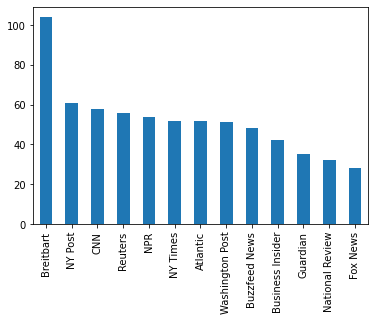

In [19]:
print("\nArticle counts by publisher:")
s= df_['publication'].value_counts()
print(s)
s.plot(kind='bar')

## Article counts by date


Article counts by date:
2016-12-02    365
2016-09-01    308
Name: date, dtype: int64


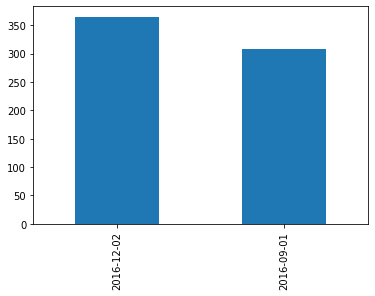

In [20]:
print("\nArticle counts by date:")
s= df_['date'].value_counts()
print(s)
s.plot(kind='bar')

# NLP Processing


## Remove Stop Words

In [0]:
def loadStopWords(stopWordsFileName):
	stop_words=[]
	f=open(stopWordsFileName, 'r')
	for l in f.readlines():
		stop_words.append(l.replace('\n', ''))
	return stop_words

stop_words=loadStopWords(runParams['stop_words_file'][0])

## NLTK pre-processing

* parts-of-speech and lemmatization


In [0]:
def stringNLTKProcess(nl,stringToConvert,partsOfSpeech,stop_words,maxWords=None,lemmatizer=None):
	sentences=nl.sent_tokenize(stringToConvert)
	str=[]
	for sentence in sentences:
		wordString=[]
		for word,pos in nl.pos_tag(nl.word_tokenize(sentence)):
			# The following condition avoids any POS which corresponds to punctuation (and takes all others)
			if partsOfSpeech==None:
				if pos[0]>='A' and pos[0]<='Z':
					wordString.append(word)
			elif pos in partsOfSpeech:
				wordString.append(word)
		for wrd in wordString:
			wrdlower=wrd.lower()
			if wrdlower not in stop_words and wrdlower!="'s":
				if maxWords==None or len(str)<maxWords:
					if lemmatizer==None:
						str.append(wrdlower)
					else:
						str.append(lemmatizer.lemmatize(wrd.lower(), pos='v'))
			if maxWords!=None and len(str)==maxWords:
				return ' '.join(str)
	return ' '.join(str)

##########################################################################################

def removeSpacesAndPunctuation(textString): 
    return "".join(i for i in textString if (ord(i)>=48 and ord(i)<=57) or (ord(i)>=97 and ord(i)<=122))

## Prepare data for analysing results



### Setup story map and testing list

In [0]:
def setupStoryMapAndReportList(args=None,reportArticleList=None,storyMapFileName=None):
	if args==None:
		articleList=reportArticleList
		fileName=storyMapFileName
	else:
		articleList=args['article_id_list']
		fileName=args['story_map_validation']

	reportArticleList=articleList
	if fileName!=None:
		storyMap=readStoryMapFromFile(fileName)
		if reportArticleList==None:
			reportArticleList=[]
			for story, articleList in storyMap.items():
				reportArticleList.append(articleList[0])
	else:
		storyMap=None
	return storyMap,reportArticleList

In [0]:
def readStoryMapFromFile(filename):
	return readDictFromCsvFile(filename,'StoryMap')

In [0]:
def readGridParameterRangeFromFile(filename):
	return readDictFromCsvFile(filename,'GridParameters')

In [0]:
def readDictFromCsvFile(filename,schema):
	gridParamDict={}
	with open(filename, 'r') as f:
		for row in f:
			row=row[:-1] # Exclude the carriage return
			row=row.split(",")
			key=row[0]
			vals=row[1:]
			
			if schema=='GridParameters':
				if key in ['story_threshold','tfidf_maxdf']:
					finalVals=list(float(n) for n in vals)
				elif key in ['ngram_max','tfidf_mindf','max_length']:
					finalVals=list(int(n) for n in vals)
				elif key in ['lemma_conversion','tfidf_binary']:
					finalVals=list(str2bool(n) for n in vals)
				elif key in ['parts_of_speech']:
					listlist=[]
					for v in vals:
						listlist.append(v.split("+"))
					finalVals=listlist
				elif key in ['tfidf_norm','nlp_library']:
					finalVals=vals
				else:
					print(key)
					print("KEY ERROR")
					return
			elif schema=='StoryMap':
				finalVals=list(int(n) for n in vals)
			else:
				print(schema)
				print("SCHEMA ERROR")
				return
			
			gridParamDict[key]=finalVals
	return gridParamDict

### Load the story map from file

In [0]:
storyMap,reportArticleList=setupStoryMapAndReportList(storyMapFileName='/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/all-news-kaggle/storyMapForValidation.csv')

In [28]:
for story, articleList in storyMap.items():
    print(story,":",articleList)

Trump meeting : [151832, 110126, 172078, 48306, 57365, 190512, 26536, 71335, 21499, 23872, 142033, 110133, 23888, 71336, 57366, 71339]
Brazil impeachment : [120639, 80103, 25225, 21502, 57362, 120636, 110141]
Kaepernick : [40617, 40543, 39520, 80109, 80101, 47403]
Clinton Guccifer : [214888, 85803, 47979]
Farage : [37252, 37468, 46175]
Anthony Weiner : [49480, 110144, 142300, 214934]
SpaceX : [38658, 134545, 172095, 214894]
Safe space : [21448, 78169, 78171]
Lauer debate : [43447, 47078, 138709]
Venezuela : [172079, 57375, 190522]
Iran deal : [158005, 48823, 57373, 120634]
Penn State : [80094, 157527, 214892]
David Brown : [172085, 80096, 141886]


In [29]:
print(reportArticleList)

[151832, 120639, 40617, 214888, 37252, 49480, 38658, 21448, 43447, 172079, 158005, 80094, 172085]


# TF-IDF Clustering Algorithm



## Vectorizing

In [0]:
def preprocessAndVectorize(articleDataFrame,args,pos_nlp_mapping,nlp,nl,wordnet_lemmatizer,stop_words):
	# Map the input parts of speech list to the coding required for the specific NLP library
	if args['parts_of_speech'][0]!='ALL':
		partsOfSpeech=[]
		for pos in args['parts_of_speech']:
			partsOfSpeech.append(pos_nlp_mapping[args['nlp_library']][pos])
		partsOfSpeech=[item for sublist in partsOfSpeech for item in sublist]
	else:
		partsOfSpeech=None

	# Processing of text depends on NLP library choice
	if  args['nlp_library']=='nltk':
		articleDataFrame['input to vectorizer']=articleDataFrame['content no nonascii'].map(lambda x: stringNLTKProcess(nl,
																									  x,
																									  partsOfSpeech=partsOfSpeech,
																									  stop_words=stop_words,
																									  maxWords=args['max_length'],
																									  lemmatizer=wordnet_lemmatizer))
	else:
		print("PROBLEM... NO VALID NLP LIBRARY... MUST BE nltk OR spaCy")

	# To get default values a couple of parameters need to be not passed if not specified on the command line
	# Passing as None behaves differently to passing no parameter (which would invoke the default value)
	optArgsForVectorizer={}
	if args['tfidf_maxdf'] != None:
		optArgsForVectorizer['max_df']=args['tfidf_maxdf']
	if args['tfidf_mindf'] != None:
		optArgsForVectorizer['min_df']=args['tfidf_mindf']

	# Create and run the vectorizer
	vectorizer=TfidfVectorizer(analyzer='word',
   	    	                   ngram_range=(1,args['ngram_max']),
       	    	               lowercase=True,
           	    	    	   binary=args['tfidf_binary'],
               		    	   norm=args['tfidf_norm'],
							   **optArgsForVectorizer)
	tfidfVectors=vectorizer.fit_transform(articleDataFrame['input to vectorizer'])
	terms=vectorizer.get_feature_names()
	return tfidfVectors, terms

## Scoring ---check to remove


In [0]:
def scoreCurrentParamGuess(tfidfVectors,storyMap,articleDataFrame,threshold,printErrors=False):


	nonZeroCoords=initialiseAllNonZeroCoords(tfidfVectors)
	score=0
	outGood=0
	outBad=0
	inGood=0
	inBad=0
	for story, storyArticles in storyMap.items():
		leadArticleIndex=articleDataFrame[articleDataFrame['id']==storyArticles[0]].index[0]
		
		scores=productRelatednessScores(tfidfVectors,nonZeroCoords,leadArticleIndex)
		rankedIndices=np.argsort(scores)
		foundRelatedArticles=[]
		
		for article in reversed(rankedIndices):
			thisArticleIndex=articleDataFrame['id'][article]
			if thisArticleIndex in storyArticles:
				if scores[article]>=threshold:
					score+=1
					inGood+=1
				else:
					score-=1
					inBad+=1
					if printErrors:
						print("ERROR:",thisArticleIndex,"should be in",story)
			else: # article not supposed to be in range
				if scores[article]<=threshold:
					score+=1
					outGood+=1
				else:
					score-=1
					outBad+=1
					if printErrors:
						print("ERROR:",thisArticleIndex,"should NOT be in",story)
	scoreDict={'score':score,'inGood':inGood,'inBad':inBad,'outGood':outGood,'outBad':outBad}
	return scoreDict

##########################################################################################

def initialiseAllNonZeroCoords(tfidfVectors):
	values=[]
	nzc=zip(*tfidfVectors.nonzero())
	pointList=[]
	for i,j in nzc:
		pointList.append([i,j])		

	for row in range(tfidfVectors.shape[0]):
		rowList=[]
		for i,j in pointList:
			if row==i:
				rowList.append(j)
		values.append(rowList)

	return values

## Relatedness Scoring measure


In [0]:
def productRelatednessScores(tfidfVectors,nonZeroCoords,refRow):
	scores=[0]*tfidfVectors.shape[0]
	for toRow in range(tfidfVectors.shape[0]):
		scores[toRow]=sum([(tfidfVectors[toRow,w]*tfidfVectors[refRow,w]) for w in nonZeroCoords[refRow] if w in nonZeroCoords[toRow]])
	return scores

## Run the algorithm


In [33]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [34]:

bestParamScoreDict={'score':-1000000}
bestParams=parameterGrid[0]
for i,currentParams in enumerate(parameterGrid):
	if len(parameterGrid)>1:
		print("Combination:",i+1,"of",len(parameterGrid))
		print(currentParams)

	
	tfidfVectors,terms=preprocessAndVectorize(articleDataFrame,currentParams,pos_nlp_mapping,nlp,nl,wordnet_lemmatizer,stop_words)

	# Compute scores if threshold provided (meaning as part of grid search)
	if 'story_threshold' in currentParams and currentParams['story_threshold']!=None:
		scoreDict=scoreCurrentParamGuess(tfidfVectors,storyMap,articleDataFrame,currentParams['story_threshold'])
		print(scoreDict)

		# Update best so far
		if scoreDict['score']>=bestParamScoreDict['score']:
			if len(parameterGrid)>1:
				print(i+1,"is the best so far!")
			bestParams=currentParams
			bestParamScoreDict=scoreDict
	# End grid/parameter loop

{'score': 3914, 'inGood': 60, 'inBad': 2, 'outGood': 3860, 'outBad': 4}


## Tidy up by restoring to best run before proceeding with analysis

In [0]:

if 'story_threshold' in bestParams and bestParams['story_threshold']!=None:
	threshold=bestParams['story_threshold']
else:
	threshold=None


# If there was a real parameter grid, then output/refresh results
if len(parameterGrid)>1:
	print("BEST PARAMETERS:")
	print(bestParams)
	print(bestParamScoreDict)
	scoreCurrentParamGuess(tfidfVectors,storyMap,articleDataFrame,threshold,printErrors=True)

	tfidfVectors,terms=preprocessAndVectorize(articleDataFrame,
											  bestParams,
											  pos_nlp_mapping,
											  nlp,
											  nl,
											  wordnet_lemmatizer,
											  stop_words)

# Analysis of results


In [0]:
# Reduce vector space to two dimensions
# Then produce Bokeh graph
def graphVectorSpace(tfidfVectors,extraColumns,dateForTitle,storyMap,threshold):
	# Better results seem to be obtained by breaking the dimensionality reduction into two steps

	# First reduce to fifty dimensions with SVD
	from sklearn.decomposition import TruncatedSVD
	svd=TruncatedSVD(n_components=50, random_state=0)
	svdResults=svd.fit_transform(tfidfVectors)

	# Next continue to two dimensions with TSNE
	from sklearn.manifold import TSNE
	tsneModel=TSNE(n_components=2, verbose=0, random_state=0, n_iter=500)
	tsneResults=tsneModel.fit_transform(svdResults)
	tfidf2dDataFrame=pd.DataFrame(tsneResults)
	tfidf2dDataFrame.columns=['x','y']

	tfidf2dDataFrame['publication']=extraColumns['publication']	
	tfidf2dDataFrame['id']=extraColumns['id']	
	tfidf2dDataFrame['content']=extraColumns['content no nonascii'].map(lambda x: x[:200])

	
	tfidf2dDataFrame['category']='STORY-0'


	if threshold==None:
		graphTitle=("TF-IDF article clustering - story assignment from map - "+dateForTitle[0])
		for story, storyArticles in storyMap.items():
			for article in storyArticles:
				if len(tfidf2dDataFrame[tfidf2dDataFrame['id']==article].index)==1:
					i=tfidf2dDataFrame[tfidf2dDataFrame['id']==article].index[0]
					tfidf2dDataFrame['category'][i]=story
	else:
		graphTitle=("TF-IDF article clustering - story assignment computed - "+dateForTitle[0])
		nonZeroCoords=initialiseAllNonZeroCoords(tfidfVectors)
		for story, storyArticles in storyMap.items():
			leadArticleIndex=extraColumns[extraColumns['id']==storyArticles[0]].index[0]
			# Compute score of all articles in corpus relative to first article in story (.product)
			scores=productRelatednessScores(tfidfVectors,nonZeroCoords,leadArticleIndex)
			rankedIndices=np.argsort(scores)
			for article in rankedIndices:
				if scores[article]>=threshold:
					tfidf2dDataFrame['category'][article]=story

	import bokeh.plotting as bp
	from bokeh.models import HoverTool
	from bokeh.plotting import show,output_notebook
	from bokeh.palettes import d3
	import bokeh.models as bmo

	output_notebook()
	plot_tfidf=bp.figure(plot_width=800, plot_height=800, title=graphTitle,
						 tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
						 x_axis_type=None, y_axis_type=None, min_border=1)

	numCats=len(tfidf2dDataFrame['category'].unique())
	palette=d3['Category20'][numCats]
	color_map=bmo.CategoricalColorMapper(factors=tfidf2dDataFrame['category'].map(str).unique(), palette=palette)

	plot_tfidf.scatter(x='x', y='y', color={'field': 'category', 'transform': color_map}, 
						legend='category',source=tfidf2dDataFrame)
	hover=plot_tfidf.select(dict(type=HoverTool))
	plot_tfidf.legend.click_policy="hide"
	hover.tooltips={"id": "@id", "publication": "@publication", "content":"@content", "category":"@category"}

	show(plot_tfidf)

## T-SNE Visualization


In [37]:
graphVectorSpace(tfidfVectors,
				 articleDataFrame[['id','publication','content no nonascii']],
				 runParams['process_date'],
				 storyMap,
				 threshold)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Investigate inferred clustering vs given story

In [0]:
def produceRequestedReportDetails(tfidfVectors,articleDataFrame,reportArticleList,threshold,storyMap,terms):

	nonZeroCoords=initialiseAllNonZeroCoords(tfidfVectors)

	topNwords=25


	storyMapGood=0.0
	encounteredStoriesList=[]
	for index,row in articleDataFrame.iterrows():
		if row['id'] in reportArticleList:
			ref_index=index
			print("-----")
			print("-----")
			print("LEAD ARTICLE IN STORY:",row['id'])
			print("-----")

			if threshold==None:
				articleIndexList=[index]
			else:
				scores=productRelatednessScores(tfidfVectors,nonZeroCoords,ref_index)
				rankedIndices=np.argsort(scores)
				numItemsInRange=sum(x>=threshold for x in scores)
				articleIndexList=rankedIndices[-numItemsInRange:]

			# If there is a story map, find out which story this article is meant to belong to
			targetStory=None
			if storyMap!=None:
				for story,articleList in storyMap.items():
					if row['id'] in articleList:
						targetStory=story
						targetArticleList=articleList
						encounteredStoriesList.append(targetStory)
					
			for article in reversed(articleIndexList):
				if targetStory!=None:
					# If this is officially part of the same story, update the counts
					if articleDataFrame['id'][article] in targetArticleList:
						storyMapGood+=1.0

				print("MEMBER ARTICLE:",articleDataFrame['id'][article])
				if threshold!=None:
					print("Score :",scores[article])
				print(articleDataFrame['publication'][article])
				print(articleDataFrame['content'][article][:500])
				print("PASSED TO VECTORIZER AS:")
				print(articleDataFrame['input to vectorizer'][article])
				print()
				printTopNwordsForArticle(tfidfVectors,terms,articleNum=article,n=topNwords)
				print("-----")
			print("-----")

	if storyMap!=None:
		storyMapSize=sum([len(storyMap[story]) for story in encounteredStoriesList])
		print("\n\nPERCENTAGE OF STORIES ALLOCATED IN LINE WITH MAP:",100.*storyMapGood/storyMapSize)

	return

def printTopNwordsForArticle(tfidfVectors,terms,articleNum,n):
	vect=tfidfVectors[articleNum].toarray()[0]
	topn1=np.argsort(vect)
	for t in reversed(topn1[-n:]):
		if vect[t]>0.001:
			print(terms[t],":",round(vect[t],5))

## Clustering output for articles


In [39]:
# Continue with outputting from best results if requested
produceRequestedReportDetails(tfidfVectors,articleDataFrame,reportArticleList,threshold,storyMap,terms)

-----
-----
LEAD ARTICLE IN STORY: 21448
-----
MEMBER ARTICLE: 21448
Score : 0.9999999999999997
NY Times
The anodyne welcome letter to incoming freshmen is a college staple, but this week the University of Chicago took a different approach: It sent new students a blunt statement opposing some hallmarks of campus political correctness, drawing thousands of impassioned responses, for and against, as it caromed around cyberspace. “Our commitment to academic freedom means that we do not support   trigger warnings, we do not cancel invited speakers because their topics might prove controversial, and we 
PASSED TO VECTORIZER AS:
incoming university chicago opposing drawing caromed academic support cancel prove condone retreat john ellison wrote arrive condoned allowed rocked yale wesleyan oberlin dismayed withheld chicago espouse explore coming dining felt kevin gannon grand view university des moines dismissed relies heritage foundation wrote facebook stand chicago greg lukianoff foundation

# Description and Insight

* This colab is used to cluster data from kaggle all news data set. This data has news from different popular media outlets from years of 2016 and July 2017
* My topic is 'News Coverage' which means I have to measure and compare news coverage of the same story published in different media outlets almost at the same timeframe. There is no label in this data set to group articles with the same story. So I have clustered the data into the same group based on their story. To clarify some terms:
 
>> * ARTICLE - a single article printed by one news publication
>> * STORY - the underlying event that an article is in reference to
 
* Preprocessing and data clean up is done using NLTK to perform following NLP preprocessing on data. 
 
>> * Removing stopwords
>> * Remove special character
>> * Remove punctuations
>> * Lowercase 
>> * Stemming 
>> * Lemmatization
>> * Removing junk and "briefing" articles
>> * Removing Daily Summary articles
>> * Removing non-ASCII characters
 
* I have used Tf-IDF based clustering. I have generated a TF-IDF matrix with the computed TF-IDF term value constraints. After that processing of the resulting vectors are done to rank their affinity. Finally grouped articles whose affinity is above the given threshold into "stories". After the first set of results I have picked some of the small cluster group data to do a manual story naming and saved it inside a file. Later I have used the file to evaluate the cluster, to visualize the cluster above using T-sne and for scoring news coverage.



# Reference

1. https://towardsdatascience.com/machine-learning-versus-the-news-3b5b479d8e6a
2. https://www.kaggle.com/arjunchandrasekhara/news-classification
3. https://medium.com/@MSalnikov/text-clustering-with-k-means-and-tf-idf-f099bcf95183
4. https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24
5. https://github.com/javedsha/text-classification
6. https://github.com/sharma-vidhi/Fake-News-Detection
7. https://www.kaggle.com/thebrownviking20/k-means-clustering-of-1-million-headlines